In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
!pip install dgl
import dgl
import torch
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 7.6 MB/s 
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [2]:
pd.set_option('display.max_columns', None)
df1 = pd.read_csv('fraudTrain.csv')
df2 = pd.read_csv('fraudTest.csv')

df1['train_mask'] = 1
df1['test_mask'] = 0
df2['train_mask'] = 0
df2['test_mask'] = 1
df = pd.concat([df1, df2])


In [13]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,train_mask,test_mask
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654.0,36.0788,-81.1781,3495.0,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1.325376e+09,36.011293,-82.048315,0.0,1,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160.0,48.8878,-118.2105,149.0,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1.325376e+09,49.159047,-118.186462,0.0,1,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252.0,42.1808,-112.2620,4154.0,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1.325376e+09,43.150704,-112.154481,0.0,1,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632.0,46.2306,-112.1138,1939.0,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1.325376e+09,47.034331,-112.561071,0.0,1,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433.0,38.4207,-79.4629,99.0,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1.325376e+09,38.674999,-78.632459,0.0,1,0


In [14]:
def encode_data(input):


    customer_node = set(df['cc_num'])
    merchant_node = set(df['merchant'])
    transaction_node = set(df['trans_num'])
    category = set(df['category'])
    city = set(df['city'])
    mapping_c = dict(zip(customer_node, range(len(customer_node))))
    mapping_m = dict(zip(merchant_node, range(len(merchant_node))))                 
    mapping_t = dict(zip(transaction_node, range(len(df))))
    mapping_cat = dict(zip(category, range(len(df))))
    mapping_city = dict(zip(city, range(len(df))))
    output = input.copy()
    output['customer_id'] = output.cc_num.apply(lambda x: mapping_c[x])
    output['merchant_id'] = output.merchant.apply(lambda x: mapping_m[x])
    output['transaction_id'] = output.trans_num.apply(lambda x: mapping_t[x])
    output['category_id'] = output.category.apply(lambda x: mapping_cat[x])
    output['city_id'] = output.city.apply(lambda x: mapping_city[x])

    return output

encoded_df = encode_data(df)

In [5]:
user_transaction = df[['cc_num', 'trans_num', 'category', 'amt', 'is_fraud']]
user_transaction.to_csv('user_transaction.csv')

In [15]:
merchant_transaction = df[['merchant', 'trans_num', 'category', 'amt', 'is_fraud']]
merchant_transaction.to_csv('merchant_transaction.csv')

In [8]:
print(df1.shape[0])
print(df2.shape[0])

7815
7798


In [9]:
print('Number of customers', pd.unique(encoded_df.customer_id).shape[0])
print('Number of customers in train', pd.unique(encoded_df[encoded_df['train_mask'] == 1].customer_id).shape[0])
print('Number of customers in test', pd.unique(encoded_df[encoded_df['test_mask'] == 1].customer_id).shape[0])
print('Number of merchants', pd.unique(encoded_df.merchant_id).shape[0])
print('Number of merchants in train', pd.unique(encoded_df[encoded_df['train_mask'] == 1].merchant_id).shape[0])
print('Number of merchants in test', pd.unique(encoded_df[encoded_df['test_mask'] == 1].merchant_id).shape[0])

Number of customers 908
Number of customers in train 897
Number of customers in test 899
Number of merchants 693
Number of merchants in train 693
Number of merchants in test 693


In [10]:
encoded_df.shape

(15613, 30)

3576431665303017    51
2720433095629877    47
4939976756738216    46
4716561796955522    46
630424987505        46
                    ..
2454076758463217     2
346243940647414      2
6526955903501879     1
373213026644490      1
5410056176712193     1
Name: cc_num, Length: 908, dtype: int64
fraud_Kilback LLC                 52
fraud_Boyer PLC                   51
fraud_Cormier LLC                 48
fraud_Dickinson Ltd               47
fraud_Witting, Beer and Ernser    43
                                  ..
fraud_Kessler Group                5
fraud_Boyer-Haley                  5
fraud_Shields Inc                  5
fraud_Goyette-Herzog               4
fraud_Rowe-Vandervort              4
Name: merchant, Length: 693, dtype: int64
0.0    15544
1.0       67
Name: is_fraud, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


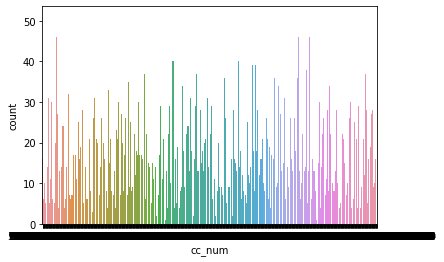

In [11]:
len(pd.unique(df.cc_num))
print(df.cc_num.value_counts())
len(pd.unique(df.merchant))
print(df.merchant.value_counts())
print(df.is_fraud.value_counts())

sns.countplot(df.cc_num)


In [16]:
encoded_df.is_fraud.value_counts()

0.0    15544
1.0       67
Name: is_fraud, dtype: int64

0.0    15544
1.0       67
Name: is_fraud, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


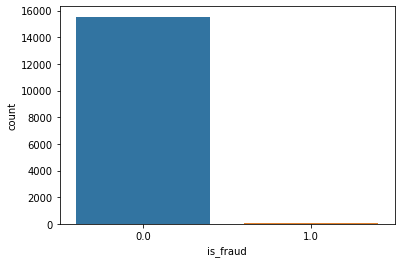

In [17]:
print(encoded_df.is_fraud.value_counts())
sns.countplot(encoded_df.is_fraud)

In [18]:
encoded_df = encode_data(df)

In [19]:
c_train = set(pd.unique(encoded_df[encoded_df['train_mask'] == 1].customer_id))
c_test = set(pd.unique(encoded_df[encoded_df['test_mask'] == 1].customer_id))

print("Number of customers in train but not in test", len(c_train.difference(c_test)))

m_train = set(pd.unique(encoded_df[encoded_df['train_mask'] == 1].merchant_id))
m_test = set(pd.unique(encoded_df[encoded_df['test_mask'] == 1].merchant_id))

print("Number of merchants in train but not in test", len(m_train.difference(m_test)))

Number of customers in train but not in test 9
Number of merchants in train but not in test 0


In [20]:
fraud_item = encoded_df[encoded_df['is_fraud'] == 1]
non_fraud_item = encoded_df[encoded_df['is_fraud'] == 0]

In [21]:
def find_relation(encoded_df):
    fraud_item = encoded_df[encoded_df['is_fraud'] == 1]
    non_fraud_item = encoded_df[encoded_df['is_fraud'] == 0]
    return

## Edge Classicication Heterogenous

In [22]:
fraud_buy_edge = [tuple(x) for x in fraud_item[['customer_id', 'merchant_id']].to_numpy()]
non_buy_edge = [tuple(x) for x in non_fraud_item[['customer_id', 'merchant_id']].to_numpy()]
fraud_sell_edge = [tuple(x) for x in fraud_item[['merchant_id', 'customer_id']].to_numpy()]
non_sell_edge = [tuple(x) for x in non_fraud_item[['merchant_id', 'customer_id']].to_numpy()]

In [23]:
hetero_graph = dgl.heterograph({('client', 'is_fraud_buy', 'merchant'):fraud_buy_edge,
                     ('client', 'not_fraud_buy', 'merchant'): non_buy_edge,
                     ('merchant', 'is_fraud_sell', 'client'): fraud_sell_edge,
                     ('merchant', 'not_fraud_sell', 'client'): non_sell_edge})

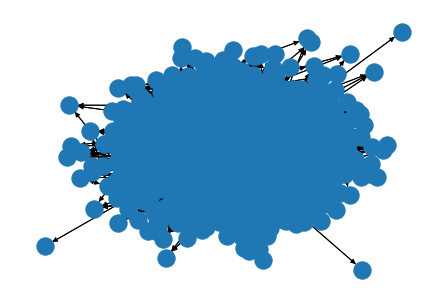

In [28]:
from matplotlib import pylab
import networkx as nx
hom = dgl.to_homogeneous(hetero_graph)
G = dgl.to_networkx(hom)

nx.draw(G)




In [29]:
client_node = encoded_df.copy()
client_amt = client_node.groupby(['customer_id']).sum().amt
client_node = client_node.groupby(['customer_id']).max()
client_node['amt'] = client_amt

merchant_node = encoded_df.copy()
merchant_amt = merchant_node.groupby(['merchant_id']).sum().amt
merchant_node = merchant_node.groupby(['merchant_id']).max()
merchant_node['amt'] = merchant_amt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  


In [30]:
hetero_graph.nodes['client'].data['feature'] = torch.tensor(client_node[['is_fraud', 'amt']].to_numpy()).float()
hetero_graph.nodes['merchant'].data['feature'] = torch.tensor(merchant_node[['is_fraud', 'amt']].to_numpy()).float()                                                              
hetero_graph.edges['is_fraud_buy'].data['train_mask'] = torch.Tensor(fraud_item['train_mask'].to_numpy()).bool()
hetero_graph.edges['is_fraud_buy'].data['test_mask'] = torch.Tensor(fraud_item['test_mask'].to_numpy()).bool()
hetero_graph.edges['not_fraud_buy'].data['train_mask'] = torch.Tensor(non_fraud_item['train_mask'].to_numpy()).bool()
hetero_graph.edges['not_fraud_buy'].data['test_mask'] = torch.Tensor(non_fraud_item['test_mask'].to_numpy()).bool()
hetero_graph.edges['is_fraud_sell'].data['train_mask'] = torch.Tensor(fraud_item['train_mask'].to_numpy()).bool()
hetero_graph.edges['is_fraud_sell'].data['test_mask'] = torch.Tensor(fraud_item['test_mask'].to_numpy()).bool()
hetero_graph.edges['not_fraud_sell'].data['train_mask'] = torch.Tensor(non_fraud_item['train_mask'].to_numpy()).bool()
hetero_graph.edges['not_fraud_sell'].data['test_mask'] = torch.Tensor(non_fraud_item['test_mask'].to_numpy()).bool()

In [31]:
hetero_graph

Graph(num_nodes={'client': 908, 'merchant': 693},
      num_edges={('client', 'is_fraud_buy', 'merchant'): 67, ('client', 'not_fraud_buy', 'merchant'): 15544, ('merchant', 'is_fraud_sell', 'client'): 67, ('merchant', 'not_fraud_sell', 'client'): 15544},
      metagraph=[('client', 'merchant', 'is_fraud_buy'), ('client', 'merchant', 'not_fraud_buy'), ('merchant', 'client', 'is_fraud_sell'), ('merchant', 'client', 'not_fraud_sell')])

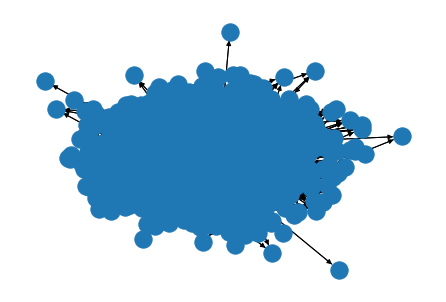

In [32]:
from matplotlib import pylab
import networkx as nx
hom = dgl.to_homogeneous(hetero_graph)
G = dgl.to_networkx(hom)

nx.draw(G)

In [33]:
dec_graph = hetero_graph['client', :, 'merchant']
edge_label = dec_graph.edata[dgl.ETYPE]

In [34]:
# Define a Heterograph Conv model

class RGCN(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats, rel_names):
        super().__init__()

        self.conv1 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(in_feats, hid_feats)
            for rel in rel_names}, aggregate='sum')
        self.conv2 = dglnn.HeteroGraphConv({
            rel: dglnn.GraphConv(hid_feats, out_feats)
            for rel in rel_names}, aggregate='sum')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = {k: F.relu(v) for k, v in h.items()}
        h = self.conv2(graph, h)
        return h

In [35]:
class HeteroMLPPredictor(nn.Module):
    def __init__(self, in_dims, n_classes):
        super().__init__()
        self.W = nn.Linear(in_dims * 2, n_classes)

    def apply_edges(self, edges):
        x = torch.cat([edges.src['h'], edges.dst['h']], 1)
        y = self.W(x)
        return {'score': y}

    def forward(self, graph, h):
        # h contains the node representations for each edge type computed from
        # the GNN for heterogeneous graphs defined in the node classification
        # section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h   # assigns 'h' of all node types in one shot
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [36]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, rel_names):
        super().__init__()
        self.sage = RGCN(in_features, hidden_features, out_features, rel_names)
        self.pred = HeteroMLPPredictor(out_features, len(rel_names))
    def forward(self, g, x, dec_graph):
        h = self.sage(g, x)
        return self.pred(dec_graph, h)

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

model = Model(2, 4, 5, hetero_graph.etypes)
client_feats = hetero_graph.nodes['client'].data['feature']
merchant_feats = hetero_graph.nodes['merchant'].data['feature']
node_features = {'client': client_feats, 'merchant': merchant_feats}

test_mask = dec_graph.edata['test_mask']
train_mask = dec_graph.edata['train_mask']

opt = torch.optim.Adam(model.parameters(), lr=0.0001)
counter = 1
for epoch in range(50):
    model.train()
    logits = model(hetero_graph, node_features, dec_graph)
    loss = F.cross_entropy(logits[train_mask], edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())
    
    model.eval()
    with torch.no_grad():
        out = model(hetero_graph, node_features, dec_graph)
        pred = out.argmax(1)
        print("Predicted")
        pred[pred==0] = 1
        pred[pred==1] = 0
        pred[pred==2] = 1
        pred[pred==3] = 0

    #     pred = model(hetero_graph, node_features)['transaction']
    #     result = hetero_graph.nodes['transaction'].data['label']
        train_acc = (pred[train_mask] == edge_label[train_mask]).float().mean()
        test_acc = (pred[test_mask] == edge_label[test_mask]).float().mean()
        print("Counter:", counter)
        print('Test Accuracy: %.2f%%' % (test_acc.item() * 100))
        print("f1_score:", f1_score(pred[test_mask], edge_label[test_mask])*100)
        print("roc_auc:", roc_auc_score(edge_label[test_mask], pred[test_mask])*100)
        print('*'*100)
        counter+=1

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

817.9298095703125
Predicted
Counter: 1
Test Accuracy: 99.50%
f1_score: 99.74927675988428
roc_auc: 49.89067524115755
****************************************************************************************************
815.7971801757812
Predicted
Counter: 2
Test Accuracy: 99.50%
f1_score: 99.74927675988428
roc_auc: 49.89067524115755
****************************************************************************************************
813.66552734375
Predicted
Counter: 3
Test Accuracy: 99.50%
f1_score: 99.74927675988428
roc_auc: 49.89067524115755
****************************************************************************************************
811.5352172851562
Predicted
Counter: 4
Test Accuracy: 99.50%
f1_score: 99.74927675988428
roc_auc: 49.89067524115755
****************************************************************************************************
809.405517578125
Predicted
Counter: 5
Test Accuracy: 99.50%
f1_score: 99.74927675988428
roc_auc: 49.89067524115755
*******************

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 9
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
798.771728515625
Predicted
Counter: 10
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
796.6482543945312
Predicted
Counter: 11
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
794.52587890625
Predicted
Counter: 12
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
792.4044189453125


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 13
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
790.2844848632812
Predicted
Counter: 14
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
788.1657104492188
Predicted
Counter: 15
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
786.0478515625
Predicted
Counter: 16
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
783.9313354492188


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 17
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
781.8158569335938
Predicted
Counter: 18
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
779.701416015625
Predicted
Counter: 19
Test Accuracy: 99.49%
f1_score: 99.74283142599974
roc_auc: 49.88424437299035
****************************************************************************************************
777.5878295898438
Predicted
Counter: 20
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
775.4754028320312


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 21
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
773.36376953125
Predicted
Counter: 22
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
771.2527465820312
Predicted
Counter: 23
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
769.142578125
Predicted
Counter: 24
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
767.0336303710938


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 25
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
764.9257202148438
Predicted
Counter: 26
Test Accuracy: 99.47%
f1_score: 99.73638526329326
roc_auc: 49.87781350482315
****************************************************************************************************
762.8185424804688
Predicted
Counter: 27
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
760.7117919921875
Predicted
Counter: 28
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
758.6057739257812


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 29
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
756.500732421875
Predicted
Counter: 30
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
754.3964233398438
Predicted
Counter: 31
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
752.293212890625
Predicted
Counter: 32
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
750.190673828125
Predicted


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Counter: 33
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
748.0889892578125
Predicted
Counter: 34
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
745.9879760742188
Predicted
Counter: 35
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
743.8877563476562
Predicted
Counter: 36
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
741.7883911132812


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 37
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
739.6898803710938
Predicted
Counter: 38
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
737.5916748046875
Predicted
Counter: 39
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
735.4942626953125
Predicted
Counter: 40
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
733.3973388671875


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Predicted
Counter: 41
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
731.30126953125
Predicted
Counter: 42
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
729.205810546875
Predicted
Counter: 43
Test Accuracy: 99.46%
f1_score: 99.72993827160495
roc_auc: 49.871382636655945
****************************************************************************************************
727.1110229492188
Predicted
Counter: 44
Test Accuracy: 99.45%
f1_score: 99.72349045077488
roc_auc: 49.864951768488744
****************************************************************************************************
725.0169067382812
Predicted


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Counter: 45
Test Accuracy: 99.45%
f1_score: 99.72349045077488
roc_auc: 49.864951768488744
****************************************************************************************************
722.923583984375
Predicted
Counter: 46
Test Accuracy: 99.45%
f1_score: 99.72349045077488
roc_auc: 49.864951768488744
****************************************************************************************************
720.8312377929688
Predicted
Counter: 47
Test Accuracy: 99.45%
f1_score: 99.72349045077488
roc_auc: 49.864951768488744
****************************************************************************************************
718.7396240234375
Predicted
Counter: 48
Test Accuracy: 99.45%
f1_score: 99.72349045077488
roc_auc: 49.864951768488744
****************************************************************************************************
716.648681640625
Predicted


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. 

Counter: 49
Test Accuracy: 99.44%
f1_score: 99.71704180064309
roc_auc: 49.858520900321544
****************************************************************************************************
714.5582275390625
Predicted
Counter: 50
Test Accuracy: 99.44%
f1_score: 99.71704180064309
roc_auc: 49.858520900321544
****************************************************************************************************


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [43]:
 hetero_graph.etypes

['is_fraud_buy', 'not_fraud_buy', 'is_fraud_sell', 'not_fraud_sell']

In [44]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score


test_mask = dec_graph.edata['test_mask']
train_mask = dec_graph.edata['train_mask']
model.eval()
with torch.no_grad():
    out = model(hetero_graph, node_features, dec_graph)
    pred = out.argmax(1)
    print("Predicted")
    pred[pred==0] = 1
    pred[pred==1] = 0
    pred[pred==2] = 1
    pred[pred==3] = 0
        
    train_acc = (pred[train_mask] == edge_label[train_mask]).float().mean()
    test_acc = (pred[test_mask] == edge_label[test_mask]).float().mean()
    print('Test Accuracy: %.2f%%' % (test_acc.item() * 100))
    
    print(f1_score(pred[test_mask], edge_label[test_mask])*100)
    print(roc_auc_score(edge_label[test_mask], pred[test_mask]))

Predicted
Test Accuracy: 99.44%
99.71704180064309
0.49858520900321546
